# **AI201 - Programming Assignment #1**
#### *Implementing the A* Algorithm*

Instructor: Dr. Pros Naval

Submitted by: Geyzson Kristoffer

October 21, 2023

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output
import time

In [13]:
# to prevent unintended modifications on my dataframe
def disabled_delete(*args, **kwargs):
    raise RuntimeError("Deletion is disabled for this DataFrame")

# Disabling df deletion methods
setattr(pd.DataFrame, "drop", disabled_delete)
setattr(pd.DataFrame, "dropna", disabled_delete)
setattr(pd.DataFrame, "drop_duplicates", disabled_delete)

In [14]:
# for rendering purposes
def render_puzzle(state, clear_prev=False):
    if clear_prev:
        clear_output(wait=True)

    fig, ax = plt.subplots(figsize=(6, 6))
    
    empty_tile_color = 'black'
    ax.set_facecolor(empty_tile_color)
    
    border_thickness = 0.05
    cell_size = 1 - 2 * border_thickness

    for i in range(3):
        for j in range(3):
            cell_value = state[i, j]
            if cell_value == '*':
                face_color = empty_tile_color
                text_color = empty_tile_color
            else:
                face_color = 'white'
                text_color = 'black'
            
            ax.add_patch(plt.Rectangle((j + border_thickness, 2 - i + border_thickness), cell_size, cell_size, facecolor=face_color, edgecolor=empty_tile_color, linewidth=2*border_thickness))
            ax.text(j + 0.5, 2 - i + 0.5, str(cell_value), size=20, ha='center', va='center', color=text_color)

    plt.title("8 Puzzle AI using A*", fontsize=16, fontweight='bold', pad=20)
    ax.text(1.5, 3.05, "Geyzson Kristoffer", ha='center', va='center', fontsize=10, fontstyle='italic')


    plt.xlim(0, 3)
    plt.ylim(0, 3)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plt.show()


In [15]:
# reading the file
def read_states(file_path):

    initial_state = []
    goal_state = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        start_index = lines.index("start\n") + 1  # Find the line after "start"
        goal_index = lines.index("goal\n") + 1  # Find the line after "goal"
        
        # Read initial state
        for i in range(start_index, start_index + 3):
            row = lines[i].strip().split(" ")
            initial_state.append([int(x) if x != '*' else '*' for x in row])
        
        # Read goal state
        for i in range(goal_index, goal_index + 3):
            row = lines[i].strip().split(" ")
            goal_state.append([int(x) if x != '*' else '*' for x in row])
            
    return np.array(initial_state), np.array(goal_state)

file_path = "astar_in.txt"  
initial_state, goal_state = read_states(file_path)

In [16]:
# heuristics

def wrong_count(state, goal_state):
    state = state.copy()
    goal_state = goal_state.copy()
    return sum([1 for i in range(len(state.flatten())) if ((state.flatten()[i] != goal_state.flatten()[i]) and (state.flatten()[i] != '*'))])

def manhattan_distance(state, goal_state):

    md_list = []
    arr = deepcopy(state)

    for i in range(len(arr[0])):
        for j in range(len(arr[1])):
            if arr[i][j] == '*':
                md_list.append(0)
                continue
            else:
                row, col = np.where(goal_state == arr[i][j])
                md_list.append(abs(col[0]-j) + abs(row[0]-i))

    return sum(md_list)

def sequence_score(state, goal_state):
    node = state.copy()
    gs = goal_state.copy()

    node_sequence = [
        node[0, 0], node[0, 1], node[0, 2],
        node[1, 2], node[2, 2], node[2, 1],
        node[2, 0], node[1, 0]
    ]
    
    actual_next = node_sequence[1:]
    actual_next.extend([node_sequence[0]])

    goal_next = [str(int(tile)+1) if tile != '*' else None for tile in node_sequence]

    try:
        goal_next[goal_next.index('9')] = '1'
    except ValueError:
        pass

    sequence_score = 0
    sequence_score = sum([2 for i in range(len(goal_next)) if (goal_next[i] != actual_next[i]) and (goal_next[i] != None)])

    if state[1, 1] != '*':
        sequence_score += 1

    return sequence_score

In [17]:
# adding row and at the same time calculating the value of the heuristic
def add_row(df, node, parent_id, heuristic):
    if node is None:
        return df

    df = df.copy()
    GS = df.loc[0, 'node']   

    g = (df.loc[parent_id, 'g'] + 1) if parent_id != None else 0
    wc = wrong_count(node, GS)
    P = manhattan_distance(node, GS)
    S = sequence_score(node, GS)
    f = 0

    if heuristic == 'wrong_count':
        f = g + wc
    elif heuristic == 'manhattan_distance':
        f = g + P
    elif heuristic == 'sequence_score':
        f = g + P + (3*S)
    
    # [7] Check if node is already in the open list
    existing_node_open = df[(df['node'].apply(lambda x: np.array_equal(x, node))) & (df['open'] == True)]
    
    if not existing_node_open.empty:
        existing_node_id = existing_node_open.iloc[0]['id']
        if f < df.loc[existing_node_id, 'f']:
            df.loc[existing_node_id, 'f'] = f
            df.loc[existing_node_id, 'g'] = g
            df.loc[existing_node_id, 'parent_id'] = parent_id
            df.loc[existing_node_id, 'open'] = True
        return df

    # [6] adding new node, putting it at the open list, and directing pointer back to n
    df.loc[len(df)] = {'id': len(df), 'node': node,
                       'f': f, 'g': g, 'wc': wc, 'P': P, 'S': S, 'parent_id': parent_id, 'open': True, 'closed': False}

    return df




In [18]:
# returns the state moved in a direction
def move(state, direction):

    arr = state.copy()
    directions = {
        'up': (-1, 0),
        'down': (1, 0),
        'left': (0, -1),
        'right': (0, 1)
    }

    row_change, col_change = directions.get(direction, (0, 0))
    new_state = deepcopy(arr)

    star_index = np.where(arr == '*')

    r, c = star_index[0][0], star_index[1][0]
    
    # if within the bounds
    if (0 <= r + row_change < len(new_state)) and (0 <= c + col_change < len(new_state[0])):
        new_state[r][c], new_state[r + row_change][c + col_change] = new_state[r + row_change][c + col_change], new_state[r][c]
        return np.array(new_state)
    else:
        return None 

In [19]:
# path tracing and animation
def trace_path(df, solution_id):
    path = []
    parent_id = solution_id
    path.append(parent_id)
    while parent_id != None:
        parent_id = df[df['id'] == parent_id]['parent_id'].iloc[0]
        path.append(parent_id)
    
    path = path[::-1]
    path = [node for node in path if node != None]

    return path

def animate_path(df, path):

    time.sleep(1)
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.text(0.5, 0.65, "Goal Reached", ha='center', va='center', fontsize=24, fontweight='bold')
    ax.text(0.5, 0.5, "Replaying the best path in", ha='center', va='center', fontsize=16)
    ax.axis('off')
    plt.show()
    time.sleep(2)  # wait for 2 seconds

    # 3-second countdown
    for count in range(3, 0, -1):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.text(0.5, 0.5, str(count), ha='center', va='center', fontsize=60, fontweight='bold')
        ax.axis('off')
        plt.show()
        time.sleep(1)  # wait for 1 second

    # play the animation
    for node_id in path:
        render_puzzle(df[df['id'] == node_id]['node'].iloc[0], clear_prev=True)
        _f = df.loc[node_id, 'f']
        _g = df.loc[node_id, 'g']
        _wc = df.loc[node_id, 'wc']
        _P = df.loc[node_id, 'P']
        _S = df.loc[node_id, 'S']

        print(f'f: {_f} | g: {_g} | wc: {_wc} | P: {_P} | S: {_S} ')
        print('total nodes expanded: ', len(df)-2)

        time.sleep(0.5)  # display each frame for 0.5 seconds


In [20]:
# astar implementation
# the numbers following the pseudocode on page 21 of Lecture 3B are indicated in the comments with []

def astar(initial_state, goal_state, heuristic, max_iterations=1000, path_animation=True):

    initial_state = initial_state.copy()
    goal_state = goal_state.copy()

    df = pd.DataFrame(columns=['id', 'node', 'f', 'g', 'wc', 'P', 'S', 'parent_id', 'open', 'closed'])

    # adding the goal node to the df as the first row so i can reference it later
    df.loc[len(df)] = {'id': len(df), 'node': goal_state, 'f': 0, 'g': 0, 'wc': 0, 'P': 0, 'S': 0, 'parent_id': 0, 'open': False, 'closed': False}

    # [1] adding the start node s to the open list and computing its f value
    df = add_row(df, initial_state, None, heuristic)

    # setting the current node to the start node s
    node = df.loc[1, 'node']


    for i in range(max_iterations):

        # [2] if open is empty, exit with failure
        if df[df['open'] == True].empty:
            print("No more nodes to explore!")
            break

        print(f'Iteration: {i}')

        # [3] looking for the node with the lowest f value in the open list
        frontier_node_id = df[df['open'] == True].sort_values(by=['f'], ascending=True).iloc[0].loc['id']

        # [3] removing the node with the lowest f value from the open list and adding it to the closed list
        df.loc[frontier_node_id, 'open'] = False
        df.loc[frontier_node_id, 'closed'] = True

        # [3] setting the current node to the node with the lowest f value
        node = df.loc[frontier_node_id, 'node']

        # displaying the current node
        render_puzzle(node, clear_prev=True)
        _f = df.loc[frontier_node_id, 'f']
        _g = df.loc[frontier_node_id, 'g']
        _wc = df.loc[frontier_node_id, 'wc']
        _P = df.loc[frontier_node_id, 'P']
        _S = df.loc[frontier_node_id, 'S']

        print('heuristic: ', heuristic)
        if heuristic == 'wrong_count':
            print(f'f: {_f} | g: {_g} | h: {_wc} ')
        elif heuristic == 'manhattan_distance':
            print(f'f: {_f} | g: {_g} | h: {_P} ')
        elif heuristic == 'sequence_score':
            print(f'f: {_f} | g: {_g} | P: {_P} | S: {_S} ')
        print('total nodes expanded: ', len(df)-2)

        # [4] if the current node is the goal node, exit with success
        if np.array_equal(node, goal_state) == True:
            # [4] tracing path
            path = trace_path(df, frontier_node_id)
            print("Goal reached!")

            if path_animation:
                animate_path(df, path)
                
            print('path taken by node id', path)
            break

        # [5] expanding node n by generating all its successors
        # the f values are computed within the add_row function
        df = add_row(df, move(node, 'up'), frontier_node_id, heuristic)
        df = add_row(df, move(node, 'down'), frontier_node_id, heuristic)
        df = add_row(df, move(node, 'left'), frontier_node_id, heuristic)
        df = add_row(df, move(node, 'right'), frontier_node_id, heuristic)


    
    return df

Run using wrong count

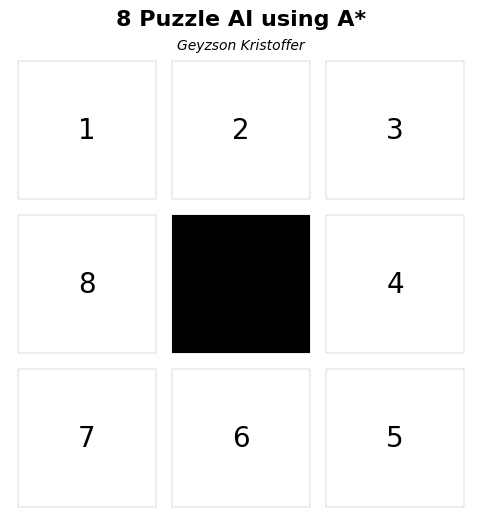

f: 18 | g: 18 | wc: 0 | P: 0 | S: 0 
total nodes expanded:  3734
path taken by node id [1, 5, 13, 23, 46, 126, 169, 375, 376, 383, 499, 957, 1611, 2064, 2672, 2675, 3430, 3611, 3612]


In [21]:
heuristics = ['wrong_count', 'manhattan_distance', 'sequence_score']

""" note:
in a local machine here are the runtimes for each heuristic:
wrong_count: 3m 2.5s
manhattan_distance: 21.4s
sequence_score: 5.0s

"""
df = astar(initial_state, goal_state,
            heuristic=heuristics[0],
            max_iterations=100000,
            path_animation=True) # set path animation to false if you only want to see the solving and not the path  

Run using manhattan distance

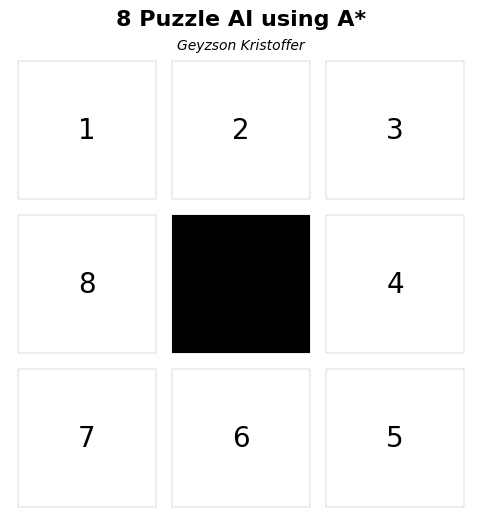

f: 18 | g: 18 | wc: 0 | P: 0 | S: 0 
total nodes expanded:  622
path taken by node id [1, 5, 9, 12, 28, 64, 157, 159, 160, 191, 200, 377, 407, 499, 529, 532, 578, 603, 604]


In [23]:
df = astar(initial_state, goal_state,
            heuristic=heuristics[1],
            max_iterations=100000,
            path_animation=True) # set path animation to false if you only want to see the solving and not the path  

Run using Nilsson's Sequence Score

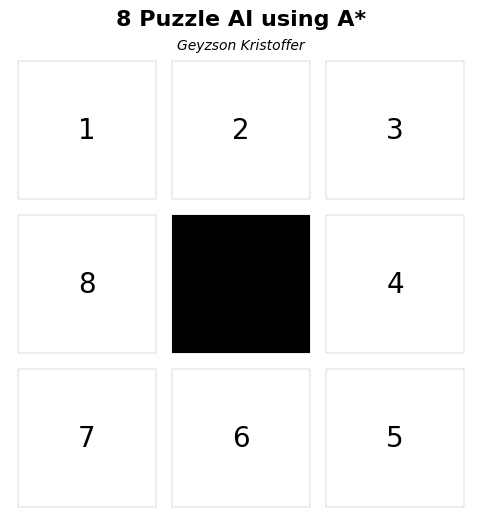

f: 18 | g: 18 | wc: 0 | P: 0 | S: 0 
total nodes expanded:  142
path taken by node id [1, 5, 9, 12, 25, 30, 32, 37, 38, 43, 45, 49, 126, 127, 131, 134, 136, 140, 141]


In [24]:
df = astar(initial_state, goal_state,
            heuristic=heuristics[2],
            max_iterations=100000,
            path_animation=True) # set path animation to false if you only want to see the solving and not the path  